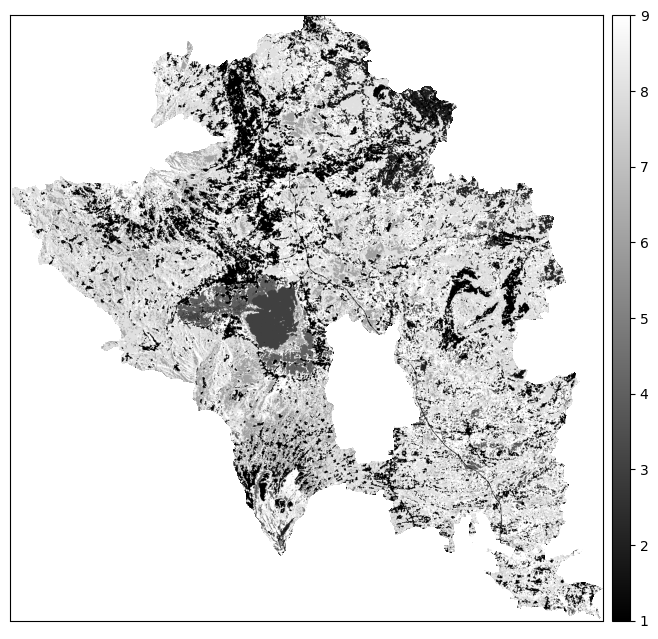

In [23]:
import tensorflow as tf                     # deep learning library. Tensors are just multi-dimensional arrays
import numpy as np                          # library to work with arrays
import matplotlib.pyplot as plt             # library for plotting
import pandas as pd                         # library for data manipulation
from ydata_profiling import ProfileReport   # library for data profiling
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report         # For evaluating the model
from sklearn.utils.class_weight import compute_class_weight                                         # For computing class weights
import matplotlib.pyplot as plt                                                                     # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
import geopandas as gpd
import os        
import sys
import matplotlib

# Parameters
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
LABEL = ['classvalue']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#006400', '#FF8C00']
CSV_PATH = 'carbon_stock_data/Yogyakarta_Carbon_Stock'
IMAGE_PATH = 'saved_data/Output_RF.tif'
# IMAGE_PATH = 'ndvi_data/Landsat_Jogja_2023_ALLFEATURES.tif'

# Load image
image = rasterio.open(IMAGE_PATH)
height = image.height
width = image.width
shape = (height, width)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Check the number of bands
num_bands = image_data.shape[0]

# If there are at least 3 bands, select the first 3 for RGB, otherwise use the available bands
if num_bands >= 3:
    # Select the first 3 bands (e.g., Red, Green, Blue)
    rgb_bands = image_data[:3]

    # Normalize the bands (0-1 range)
    rgb_bands = rgb_bands / np.max(rgb_bands)  # Normalize by the maximum value

    # Visualize the image as RGB
    ep.plot_rgb(rgb_bands, figsize=(8, 8), stretch=True)  # Stretch for better contrast
else:
    # If the image has only one band, visualize it as grayscale (without 'stretch' argument)
    ep.plot_bands(image_data[0], figsize=(8, 8), cmap="gray")

# Show the plot
plt.show()


In [47]:
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the image using rasterio
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Normalize the data (subtract mean, divide by standard deviation)
image_data_flat = tf.cast(image_data_flat, dtype=tf.float32)

# Manually normalize by subtracting mean and dividing by std deviation across bands
mean, variance = tf.nn.moments(image_data_flat, axes=[0])
stddev = tf.sqrt(variance)

# Normalize the data: (data - mean) / stddev
image_data_normalized = (image_data_flat - mean) / stddev

# Convert normalized data to numpy for sklearn compatibility
image_data_normalized_np = image_data_normalized.numpy()

# Function to get initial centroids based on class indices
def get_initial_centroids(X, class_indices):
    initial_centroids = []
    for idx in class_indices:
        initial_centroids.append(X[idx])
    return np.array(initial_centroids)

# Define class indices corresponding to classes 1, 4, 6, 8 (adjusted to 0-indexed)
class_indices = [0, 3, 5, 7]  # 0-indexed class positions corresponding to classes 1, 4, 6, 8

# Get the initial centroids based on the given class indices
initial_centroids = get_initial_centroids(image_data_normalized_np, class_indices)

# Initialize KMeans with custom centroids
kmeans = KMeans(n_clusters=4, init=initial_centroids, n_init=1)

# Fit the KMeans model
kmeans.fit(image_data_normalized_np)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Reshape the cluster labels back to the image dimensions
labels_reshaped = labels.reshape((height, width))

# Define custom color palette (4 colors for 4 clusters)
custom_palette = [
    '#00AA00',  # Green for Cluster 1
    '#FF0000',  # Red for Cluster 0
    '#FFFF00',   # Yellow for Cluster 3
    '#0000FF',  # Blue for Cluster 2
]

# Map each label to its corresponding color from the palette
cluster_colors = np.array([custom_palette[label] for label in labels])  # (n_samples,)
cluster_colors = cluster_colors.reshape((height, width))  # Reshape to image dimensions (height, width)

# Convert HEX colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

# Convert the color hex list to RGB
cluster_rgb = np.array([hex_to_rgb(c) for c in cluster_colors.flatten()])
cluster_rgb = cluster_rgb.reshape((height, width, 3))  # Reshape to image dimensions (height, width, 3)

# Visualize the clustered image with custom colors
plt.figure(figsize=(8, 8))
plt.imshow(cluster_rgb, interpolation='nearest')
plt.title("Clustering of Image into 4 Groups with Custom Colors")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

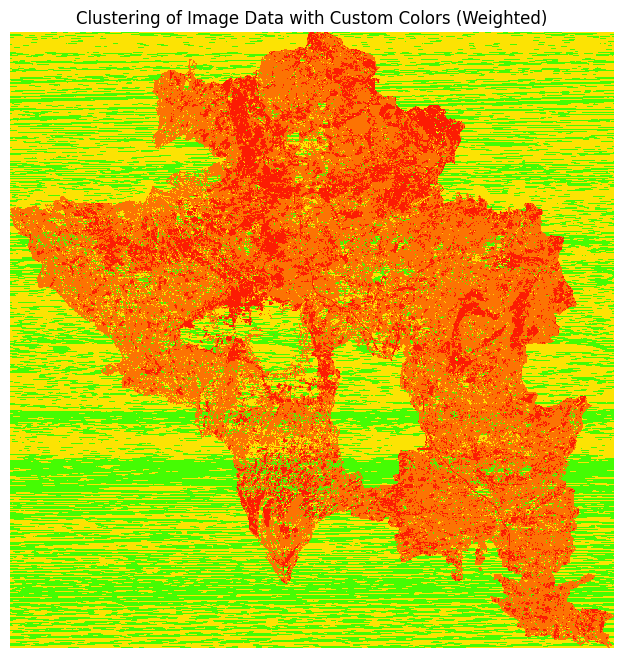

Clustered image saved to: clustered_image_output_weighted.tif


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load the image using rasterio
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions (height, width)
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Step 2: Load CSV data
csv_path = 'carbon_stock_data/Semarang_Carbon_Stock.csv'
csv_data = pd.read_csv(csv_path)

# Extract the features (replace with your actual feature columns)
csv_features = csv_data[['CA', 'CB', 'CS']].values

# Step 3: Reshape the carbon data to 2D
num_csv_rows = csv_features.shape[0]
csv_grid_height = int(np.sqrt(num_csv_rows))
csv_grid_width = num_csv_rows // csv_grid_height

# Adjust for any remaining rows
csv_features_2d = csv_features[:csv_grid_height * csv_grid_width].reshape(csv_grid_height, csv_grid_width, -1)

# Interpolate or resample the carbon grid to match the image dimensions
from scipy.ndimage import zoom

scale_height = height / csv_grid_height
scale_width = width / csv_grid_width
csv_features_resized = zoom(csv_features_2d, (scale_height, scale_width, 1), order=1)

# Step 4: Flatten the resized carbon data
csv_features_resized_flat = csv_features_resized.reshape((-1, csv_features_resized.shape[2]))

# Step 5: Normalize the data
scaler = StandardScaler()

# Normalize the image data (flattened)
image_data_normalized = scaler.fit_transform(image_data_flat)

# Normalize the resized CSV features
csv_features_normalized = scaler.fit_transform(csv_features_resized_flat)

# Step 6: Apply weights to the features
tif_weight = 5  # Give more importance to the TIF data
carbon_weight = 1  # Give less importance to the carbon data

weighted_image_data = image_data_normalized * tif_weight
weighted_carbon_data = csv_features_normalized * carbon_weight

# Combine the weighted features
combined_features = np.hstack((weighted_image_data, weighted_carbon_data))

# Step 7: Apply KMeans clustering using scikit-learn
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)

# Fit the model
kmeans.fit(combined_features)

# Get the cluster labels
labels = kmeans.labels_

# Step 8: Reshape the labels back to the image dimensions
labels_reshaped = labels.reshape(height, width)

# Step 9: Create a new TIFF image with cluster labels
output_path = 'clustered_image_output_weighted.tif'
profile = image.profile  # Use the same profile as the input image
profile.update(dtype=rasterio.uint8, count=1)  # Update profile for single-band integer data

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(labels_reshaped.astype(np.uint8), 1)

# Step 10: Visualize the clustered image with custom colors (optional)
custom_palette = [
    '#fc1c03',  # Red for Cluster 0
    '#fc7303',  # Orange for Cluster 1
    '#fce303',  # Yellow for Cluster 2
    '#45fc03'   # Green for Cluster 3
]

# Map each label to its corresponding color from the palette
cluster_colors = np.array([custom_palette[label] for label in labels])  # (n_samples,)
cluster_colors = cluster_colors.reshape(height, width)  # Reshape to image dimensions (height, width)

# Convert HEX colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

# Convert the color hex list to RGB
cluster_rgb = np.array([hex_to_rgb(c) for c in cluster_colors.flatten()])
cluster_rgb = cluster_rgb.reshape(height, width, 3)  # Reshape to image dimensions (height, width, 3)

# Step 11: Visualize the clustered image with custom colors
plt.figure(figsize=(8, 8))
plt.imshow(cluster_rgb, interpolation='nearest')
plt.title("Clustering of Image Data with Custom Colors (Weighted)")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

print(f"Clustered image saved to: {output_path}")


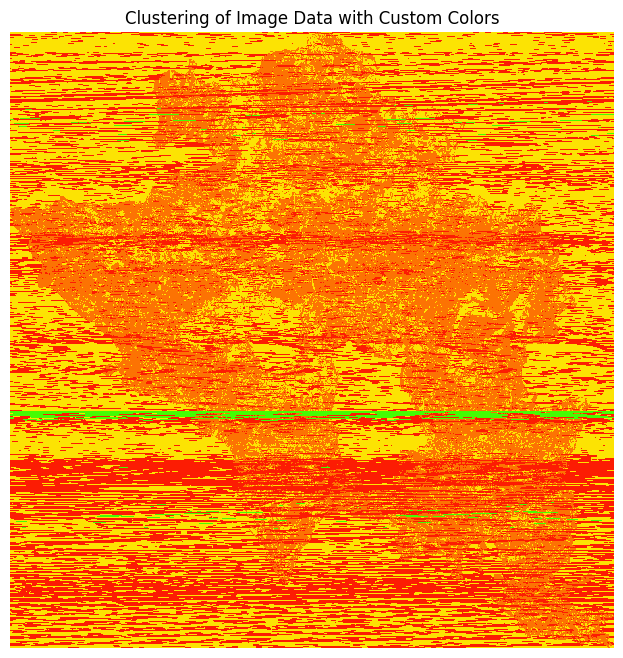

Clustered image saved to: saved_data/clustered_image_output.tif


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load the image using rasterio
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions (height, width)
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Step 2: Load CSV data
csv_path = 'carbon_stock_data/Semarang_Carbon_Stock.csv'
csv_data = pd.read_csv(csv_path)

# Extract the features (replace with your actual feature columns)
csv_features = csv_data[['CA', 'CB', 'CS']].values

# Step 3: Reshape the carbon data to 2D
# Assume the carbon data should align with the image in some logical grid
num_csv_rows = csv_features.shape[0]
csv_grid_height = int(np.sqrt(num_csv_rows))
csv_grid_width = num_csv_rows // csv_grid_height

# Adjust for any remaining rows
csv_features_2d = csv_features[:csv_grid_height * csv_grid_width].reshape(csv_grid_height, csv_grid_width, -1)

# Interpolate or resample the carbon grid to match the image dimensions
from scipy.ndimage import zoom

scale_height = height / csv_grid_height
scale_width = width / csv_grid_width
csv_features_resized = zoom(csv_features_2d, (scale_height, scale_width, 1), order=1)

# Step 4: Flatten the resized carbon data
csv_features_resized_flat = csv_features_resized.reshape((-1, csv_features_resized.shape[2]))

# Step 5: Normalize the data
scaler = StandardScaler()

# Normalize the image data (flattened)
image_data_normalized = scaler.fit_transform(image_data_flat)

# Normalize the resized CSV features
csv_features_normalized = scaler.fit_transform(csv_features_resized_flat)

# Step 6: Combine the normalized image data and CSV features
combined_features = np.hstack((image_data_normalized, csv_features_normalized))

# Step 7: Apply KMeans clustering using scikit-learn
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)

# Fit the model
kmeans.fit(combined_features)

# Get the cluster labels
labels = kmeans.labels_

# Step 8: Reshape the labels back to the image dimensions
labels_reshaped = labels.reshape(height, width)

# Step 9: Create a new TIFF image with cluster labels
output_path = 'saved_data/clustered_image_output.tif'
profile = image.profile  # Use the same profile as the input image
profile.update(dtype=rasterio.uint8, count=1)  # Update profile for single-band integer data

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(labels_reshaped.astype(np.uint8), 1)

# Step 10: Visualize the clustered image with custom colors (optional)
custom_palette = [
    '#fc1c03',  # Red for Cluster 0
    '#fc7303',  # Orange for Cluster 1
    '#fce303',  # Yellow for Cluster 2
    '#45fc03'   # Green for Cluster 3
]

# Map each label to its corresponding color from the palette
cluster_colors = np.array([custom_palette[label] for label in labels])  # (n_samples,)
cluster_colors = cluster_colors.reshape(height, width)  # Reshape to image dimensions (height, width)

# Convert HEX colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

# Convert the color hex list to RGB
cluster_rgb = np.array([hex_to_rgb(c) for c in cluster_colors.flatten()])
cluster_rgb = cluster_rgb.reshape(height, width, 3)  # Reshape to image dimensions (height, width, 3)

# Step 11: Visualize the clustered image with custom colors
plt.figure(figsize=(8, 8))
plt.imshow(cluster_rgb, interpolation='nearest')
plt.title("Clustering of Image Data with Custom Colors")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

print(f"Clustered image saved to: {output_path}")


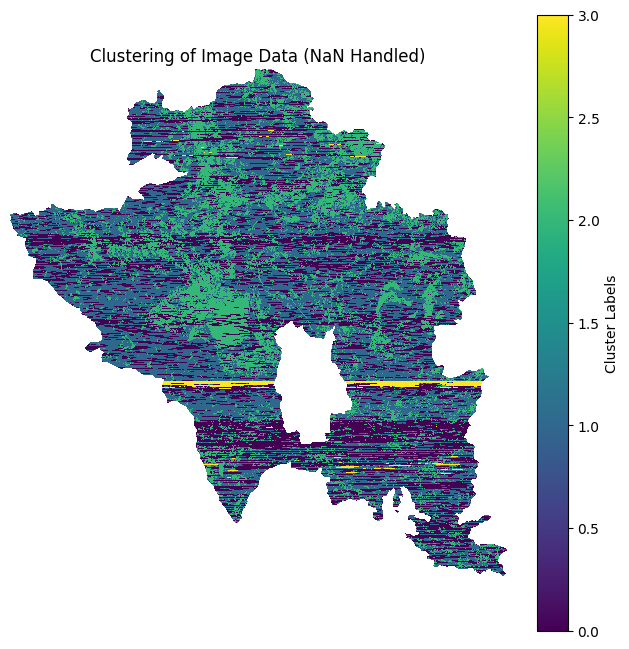

Clustered image saved to: saved_data/clustered_image_output.tif


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import zoom

# Step 1: Load the image using rasterio
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions (height, width)
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Step 2: Load CSV data
csv_path = 'carbon_stock_data/Semarang_Carbon_Stock.csv'
csv_data = pd.read_csv(csv_path)

# Extract the features (replace with your actual feature columns)
csv_features = csv_data[['CA', 'CB', 'CS']].values

# Step 3: Reshape the carbon data to 2D
num_csv_rows = csv_features.shape[0]
csv_grid_height = int(np.sqrt(num_csv_rows))
csv_grid_width = num_csv_rows // csv_grid_height

# Adjust for any remaining rows
csv_features_2d = csv_features[:csv_grid_height * csv_grid_width].reshape(csv_grid_height, csv_grid_width, -1)

# Interpolate or resample the carbon grid to match the image dimensions
scale_height = height / csv_grid_height
scale_width = width / csv_grid_width
csv_features_resized = zoom(csv_features_2d, (scale_height, scale_width, 1), order=1)

# Step 4: Flatten the resized carbon data
csv_features_resized_flat = csv_features_resized.reshape((-1, csv_features_resized.shape[2]))

# Step 5: Create a mask to track NaN values
nan_mask = np.isnan(image_data_flat).any(axis=1) | np.isnan(csv_features_resized_flat).any(axis=1)

# Step 6: Normalize the data
scaler = StandardScaler()

# Normalize only valid pixels (non-NaN)
valid_image_data = image_data_flat[~nan_mask]
valid_csv_data = csv_features_resized_flat[~nan_mask]

image_data_normalized = scaler.fit_transform(valid_image_data)
csv_features_normalized = scaler.fit_transform(valid_csv_data)

# Step 7: Combine the normalized data
combined_features = np.hstack((image_data_normalized, csv_features_normalized))

# Step 8: Apply KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans.fit(combined_features)

# Get the cluster labels for valid pixels
valid_labels = kmeans.labels_

# Step 9: Create a full array for cluster labels
labels_full = np.full(image_data_flat.shape[0], np.nan)  # Initialize with NaN
labels_full[~nan_mask] = valid_labels  # Assign valid labels to non-NaN pixels

# Step 10: Reshape labels back to the image dimensions
labels_reshaped = labels_full.reshape(height, width)

# Step 11: Save the clustered image
output_path = 'saved_data/clustered_image_output.tif'
profile = image.profile  # Use the same profile as the input image
profile.update(dtype=rasterio.float32, count=1)  # Update profile for single-band float data

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(labels_reshaped.astype(np.float32), 1)

# Step 12: Visualize the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(labels_reshaped, cmap='viridis', interpolation='nearest')
plt.title("Clustering of Image Data (NaN Handled)")
plt.colorbar(label="Cluster Labels")
plt.axis('off')
plt.show()

print(f"Clustered image saved to: {output_path}")


Combined features shape: (1137706, 4)


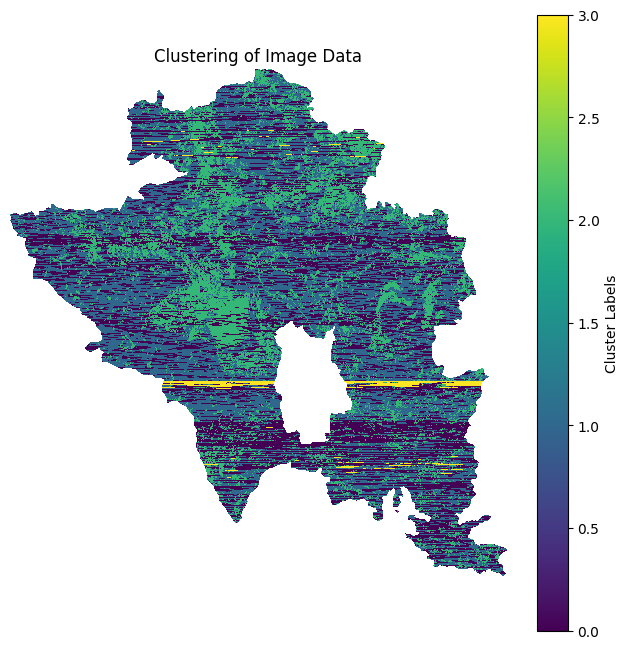

Clustered image saved to: saved_data/clustered_image_output.tif


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import zoom

# Step 1: Load the image using rasterio
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions (height, width)
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Step 2: Load CSV data
csv_path = 'carbon_stock_data/Semarang_Carbon_Stock.csv'
csv_data = pd.read_csv(csv_path)

# Extract the features (replace with your actual feature columns)
csv_features = csv_data[['CA', 'CB', 'CS']].values

# Step 3: Reshape the carbon data to 2D
num_csv_rows = csv_features.shape[0]
csv_grid_height = int(np.sqrt(num_csv_rows))
csv_grid_width = num_csv_rows // csv_grid_height

# Adjust for any remaining rows
csv_features_2d = csv_features[:csv_grid_height * csv_grid_width].reshape(csv_grid_height, csv_grid_width, -1)

# Interpolate or resample the carbon grid to match the image dimensions
scale_height = height / csv_grid_height
scale_width = width / csv_grid_width
csv_features_resized = zoom(csv_features_2d, (scale_height, scale_width, 1), order=3)  # Use cubic interpolation for smoother results

# Step 4: Flatten the resized carbon data
csv_features_resized_flat = csv_features_resized.reshape((-1, csv_features_resized.shape[2]))

# Step 5: Create a mask to track NaN values
nan_mask = np.isnan(image_data_flat).any(axis=1) | np.isnan(csv_features_resized_flat).any(axis=1)

# Step 6: Normalize the data
scaler = StandardScaler()

# Normalize only valid pixels (non-NaN)
valid_image_data = image_data_flat[~nan_mask]
valid_csv_data = csv_features_resized_flat[~nan_mask]

image_data_normalized = scaler.fit_transform(valid_image_data)
csv_features_normalized = scaler.fit_transform(valid_csv_data)

# Step 7: Combine the normalized data
combined_features = np.hstack((image_data_normalized, csv_features_normalized))

# Debugging: Verify dimensions
print(f"Combined features shape: {combined_features.shape}")

# Step 8: Apply KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)  # Default centroid initialization
kmeans.fit(combined_features)

# Get the cluster labels for valid pixels
valid_labels = kmeans.labels_

# Step 9: Create a full array for cluster labels
labels_full = np.full(image_data_flat.shape[0], np.nan)  # Initialize with NaN
labels_full[~nan_mask] = valid_labels  # Assign valid labels to non-NaN pixels

# Step 10: Reshape labels back to the image dimensions
labels_reshaped = labels_full.reshape(height, width)

# Step 11: Save the clustered image
output_path = 'saved_data/clustered_image_output.tif'
profile = image.profile  # Use the same profile as the input image
profile.update(dtype=rasterio.float32, count=1)  # Update profile for single-band float data

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(labels_reshaped.astype(np.float32), 1)

# Step 12: Visualize the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(labels_reshaped, cmap='viridis', interpolation='nearest')
plt.title("Clustering of Image Data")
plt.colorbar(label="Cluster Labels")
plt.axis('off')
plt.show()

print(f"Clustered image saved to: {output_path}")


Number of valid pixels in TIF: 1137706
Number of rows in CSV: 1119827
Downsampled image data shape: (1119827, 1)
Combined features shape: (1119827, 4)
Cluster labels shape: (1119827,)


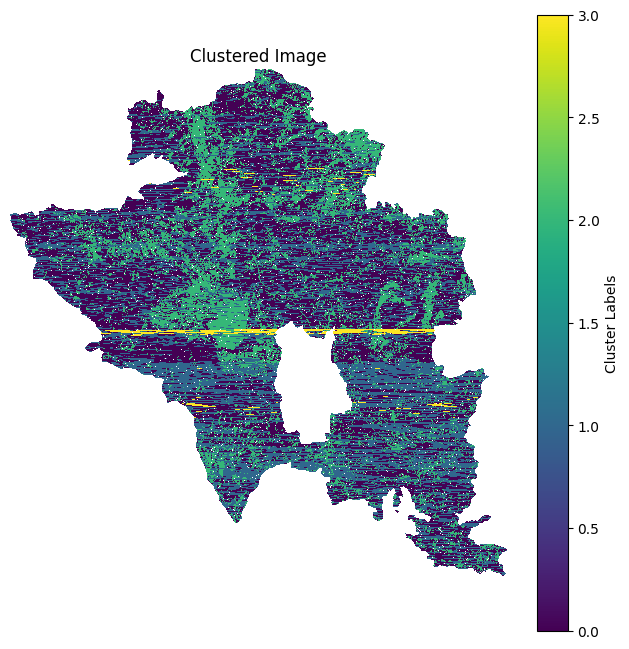

Clustered image saved to: saved_data/clustered_image_output.tif


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load the TIF image
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions (height, width)
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Step 2: Exclude NaN pixels
nan_mask = np.isnan(image_data_flat).any(axis=1)  # Mask for NaN rows
valid_image_data = image_data_flat[~nan_mask]  # Exclude NaN pixels
print(f"Number of valid pixels in TIF: {valid_image_data.shape[0]}")

# Step 3: Load CSV data
csv_path = 'carbon_stock_data/Semarang_Carbon_Stock.csv'
csv_data = pd.read_csv(csv_path)

# Extract the features (replace with your actual feature columns)
csv_features = csv_data[['CA', 'CB', 'CS']].values
print(f"Number of rows in CSV: {csv_features.shape[0]}")

# Step 4: Downsample the valid TIF pixels to match the number of CSV rows
num_csv_rows = csv_features.shape[0]
downsampled_indices = np.linspace(0, valid_image_data.shape[0] - 1, num=num_csv_rows, dtype=int)
downsampled_image_data = valid_image_data[downsampled_indices]

print(f"Downsampled image data shape: {downsampled_image_data.shape}")

# Step 5: Normalize both datasets
scaler = StandardScaler()

image_data_normalized = scaler.fit_transform(downsampled_image_data)
csv_features_normalized = scaler.fit_transform(csv_features)

# Combine the normalized TIF and CSV data
combined_features = np.hstack((image_data_normalized, csv_features_normalized))
print(f"Combined features shape: {combined_features.shape}")

# Step 6: Apply KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(combined_features)

# Get cluster labels
cluster_labels = kmeans.labels_
print(f"Cluster labels shape: {cluster_labels.shape}")

# Step 7: Create a full array for the clustered data
# Start with an empty array (NaN for invalid pixels)
clustered_full = np.full(valid_image_data.shape[0], np.nan)

# Assign labels to the valid pixels in the downsampled indices
for i, idx in enumerate(downsampled_indices):
    clustered_full[idx] = cluster_labels[i]

# Step 8: Map clustered_full back to the full array, including NaN pixels
full_clustered_image = np.full(image_data_flat.shape[0], np.nan)
full_clustered_image[~nan_mask] = clustered_full

# Step 9: Reshape the clustered data back to the original TIF dimensions
clustered_image = full_clustered_image.reshape(height, width)

# Step 10: Save the clustered image as a new TIF file
output_path = 'saved_data/clustered_image_output.tif'
profile = image.profile
profile.update(dtype=rasterio.float32, count=1)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(clustered_image.astype(np.float32), 1)

# Step 11: Visualize the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(clustered_image, cmap='viridis', interpolation='nearest')
plt.title("Clustered Image")
plt.colorbar(label="Cluster Labels")
plt.axis('off')
plt.show()

print(f"Clustered image saved to: {output_path}")


Number of valid pixels in TIF: 1137706
Number of rows in CSV: 1119827
Downsampled image data shape: (1119827, 1)
Combined features shape: (1119827, 4)
Cluster labels shape: (1119827,)


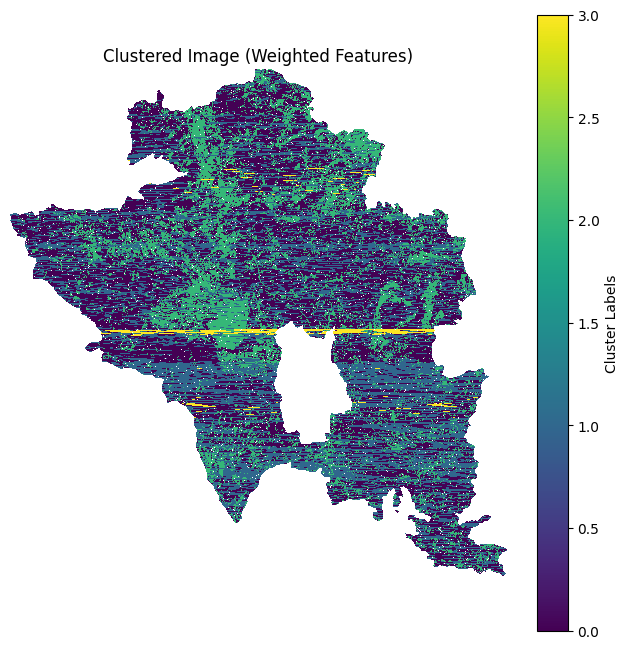

Clustered image saved to: saved_data/clustered_image_output_weighted.tif


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load the TIF image
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions (height, width)
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Step 2: Exclude NaN pixels
nan_mask = np.isnan(image_data_flat).any(axis=1)  # Mask for NaN rows
valid_image_data = image_data_flat[~nan_mask]  # Exclude NaN pixels
print(f"Number of valid pixels in TIF: {valid_image_data.shape[0]}")

# Step 3: Load CSV data
csv_path = 'carbon_stock_data/Semarang_Carbon_Stock.csv'
csv_data = pd.read_csv(csv_path)

# Extract the features (replace with your actual feature columns)
csv_features = csv_data[['CA', 'CB', 'CS']].values
print(f"Number of rows in CSV: {csv_features.shape[0]}")

# Step 4: Downsample the valid TIF pixels to match the number of CSV rows
num_csv_rows = csv_features.shape[0]
downsampled_indices = np.linspace(0, valid_image_data.shape[0] - 1, num=num_csv_rows, dtype=int)
downsampled_image_data = valid_image_data[downsampled_indices]

print(f"Downsampled image data shape: {downsampled_image_data.shape}")

# Step 5: Normalize both datasets
scaler = StandardScaler()

image_data_normalized = scaler.fit_transform(downsampled_image_data)
csv_features_normalized = scaler.fit_transform(csv_features)

# Step 6: Apply weights to the features
image_weight = 1  # Weight for TIF data
csv_weight = 1    # Weight for CSV data

weighted_image_data = image_data_normalized * image_weight
weighted_csv_features = csv_features_normalized * csv_weight

# Combine the weighted TIF and CSV data
combined_features = np.hstack((weighted_image_data, weighted_csv_features))
print(f"Combined features shape: {combined_features.shape}")

# Step 7: Apply KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(combined_features)

# Get cluster labels
cluster_labels = kmeans.labels_
print(f"Cluster labels shape: {cluster_labels.shape}")

# Step 8: Create a full array for the clustered data
# Start with an empty array (NaN for invalid pixels)
clustered_full = np.full(valid_image_data.shape[0], np.nan)

# Assign labels to the valid pixels in the downsampled indices
for i, idx in enumerate(downsampled_indices):
    clustered_full[idx] = cluster_labels[i]

# Step 9: Map clustered_full back to the full array, including NaN pixels
full_clustered_image = np.full(image_data_flat.shape[0], np.nan)
full_clustered_image[~nan_mask] = clustered_full

# Step 10: Reshape the clustered data back to the original TIF dimensions
clustered_image = full_clustered_image.reshape(height, width)

# Step 11: Save the clustered image as a new TIF file
output_path = 'saved_data/clustered_image_output_weighted.tif'
profile = image.profile
profile.update(dtype=rasterio.float32, count=1)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(clustered_image.astype(np.float32), 1)

# Step 12: Visualize the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(clustered_image, cmap='viridis', interpolation='nearest')
plt.title("Clustered Image (Weighted Features)")
plt.colorbar(label="Cluster Labels")
plt.axis('off')
plt.show()

print(f"Clustered image saved to: {output_path}")


In [36]:
image_data_flat[image_data_flat>=1].shape

(1137706,)

In [10]:
num_csv_rows.shape

AttributeError: 'int' object has no attribute 'shape'

In [11]:
csv_features_2d.shape

(1058, 1058, 3)

In [13]:
csv_features_resized_flat.shape

(2360592, 3)

In [37]:
csv_features.shape

(1119827, 3)

In [38]:
print(f"Number of valid pixels in TIF: {np.sum(~np.isnan(image_data_flat).any(axis=1))}")
print(f"Number of rows in CSV: {csv_features.shape[0]}")


Number of valid pixels in TIF: 1137706
Number of rows in CSV: 1119827
